Here we are basicly replicating my [Human Protein Atlas coexpression](https://github.com/TomConlin/human_protein_atlas_coexpression) notebook but with BGEE expression data

In [1]:
import csv
import re
#import array
import numpy as np
import matplotlib.pyplot as plt
import statistics
import requests
import json
import yaml
import re
import os
import networkx as nx
import datetime
import operator

In [2]:
# reduce ordered catagories to numbers 
# if level is unreported default to zero
levels = {
    'absent' : -1,
    'present': 1
}

reliabilities = {
    'gold quality' : 2,    # 2,921,827
    'silver quality' : 1,  # 5,837,817
    'bronze quality' : 0   #   124,978
}

# have seen including all  g/s/b  results in too many edges
# can see filtering out bronze is apt to be a minor effect
# trying just using gold

In [3]:
a = [1,1,1,0,0,0,-1,-1,-1]
b = [1,0,-1,1,0,-1,1,0,-1]

for i in range(9):
    print(a[i],b[i],a[i] * b[i])

1 1 1
1 0 0
1 -1 -1
0 1 0
0 0 0
0 -1 0
-1 1 -1
-1 0 0
-1 -1 1


Note that:  
 - agreement positive or negative add
 - disagreement postive or negative subtract 
 - any comparison with unreported stays unreported

In [4]:
for i in range(9):
    print(a[i],b[i],a[i] & b[i])

1 1 1
1 0 0
1 -1 1
0 1 0
0 0 0
0 -1 0
-1 1 1
-1 0 0
-1 -1 -1


note:  logical AND 
 - inconsistant capture of concordancce
 - sufficent capture of reported-ness
 - cheaper than multiply (should be)

### Take N+1  

Since we are longer keping absent calls we don't need to handle three states
will no longer need to multiply or dot product.  

Also means the the number of nonzeros in either of the comparison pair is an insufficent benchmark  and the number of non zeros in the combined pair is  the value to compare with the benchmark so... the benchmark has to be the average number of non zeros in the pair

score = 2*nz(a&b)/nz(a)+nz(b)

for starters still only keep score == 1 
we can lower it if need be  

Use the tissue measurement frequency to set the order for tissue profile recording

In [60]:
file = 'tissue_count_gold_present.tab' 
# count tissue_id
tissue_index = {}
with open(file, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t')
    #csvreader.__next__()  # header
    line_number = 0
    for line in csvreader:
        (count, tissue_id) = line
        tissue_index[tissue_id] = line_number
        line_number += 1
tissue_length = len(tissue_index)     

In [62]:
print('how many tissues: ', tissue_length)

how many tissues:  161


In [67]:
file = 'Homo_sapiens_expr_gold_present.tsv'
#1:Gene ID
#2:"Gene name"
#3:Anatomical entity ID
#4:"Anatomical entity name"
#5:Expression
#6:Call quality
#7:Expression rank

# make places to stash stuff 
gene_tissue = {}
#gene_tissue_rank_curve = {}
tissue_names = {}
gene_names = {}

with open(file, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t', quotechar='"')
    # csvreader.__next__()  # no header on gold file
    for line in csvreader:
        # print(line)
        (gene_id, gene_name, tissue_id, tissue_name, level, reliability, rank) = line
        # record the measurement   
        if gene_id in gene_tissue:
            gene_tissue[gene_id][tissue_index[tissue_id]] = levels[level]
        else:
            gene_tissue[gene_id] = np.array([0] * tissue_length)
            gene_tissue[gene_id][tissue_index[tissue_id]] = levels[level]

        # save human friendly tissue label 
        if tissue_id not in tissue_names:
            tissue_names[tissue_id] = tissue_name
        
        # save human friendly gene symbol 
        if gene_id not in gene_names:
            gene_names[gene_id] = gene_name

In [68]:
len(gene_tissue)

55196

In [69]:
sum(gene_tissue['ENSG00000002330'] * gene_tissue['ENSG00000003402'])

91

In [70]:
np.dot(gene_tissue['ENSG00000002330'], gene_tissue['ENSG00000003402'])

91

In [71]:
#np.dot(gene_tissue['ENSG00000002330'], gene_tissue['ENSG00000003402'])/
np.count_nonzero(np.bitwise_and(gene_tissue['ENSG00000002330'],gene_tissue['ENSG00000003402']))

91

With this relative scoring scheme I am trying to normalize based only the reported measures
that is; an unreported measurement is not counted as penalty alowing more "perfect matches"  

however since this normalization is unique for each pair of genes  
it means comparing scores between different pairs is not as meaningful.


In [81]:
np.dot(gene_tissue['ENSG00000002330'], gene_tissue['ENSG00000003402'])/len(gene_tissue['ENSG00000003402'])

0.56521739130434778

this "absolute" normalizing does allow different pairs to be compared, but I expect vanishingly few will top out even if they agree on all available points.

Probably keep both, and use the relative score to surface interesting associations 
and the absolute to give people something they can compare. 

#### Take N+1



In [82]:
# how many tissues are both genes expressed in together
np.count_nonzero(
    np.bitwise_and(gene_tissue['ENSG00000002330'],
                   gene_tissue['ENSG00000003402']
                  )
)

91

In [83]:
# how many tissues are both genes expressed in seperatly
(np.count_nonzero(
    gene_tissue['ENSG00000002330']
) 
+
np.count_nonzero(
    gene_tissue['ENSG00000003402']
))

220

In [85]:
2*np.count_nonzero(
    np.bitwise_and(gene_tissue['ENSG00000002330'],
                   gene_tissue['ENSG00000003402']
                  )
)/(np.count_nonzero(
    gene_tissue['ENSG00000002330']
) 
+
np.count_nonzero(
    gene_tissue['ENSG00000003402']
))

0.8272727272727273

In [13]:
# save a copy 
#with open('gene_tissue_curve.yaml', 'w') as fh:
#    yaml.dump(gene_tissue, fh)
# Ack! can't dump numpy arrays like this they are binary   

# gene_tissue.savetext('gene_tissue_curve.txt')
# nor like that because the container is not numpy 

In [86]:
genes = list(gene_tissue) # need a fixed order
genlen = len(genes)
gtlen = len(gene_tissue[genes[1]])

print("number of ensembl genes: ", genlen)
print("total number of tissues: ", gtlen)
genes[1]

# note: thanks to the opaqueness of the datastructures 
# we have no idea how we are hopping around in memory
# while marching straight down this list.

number of ensembl genes:  55196
total number of tissues:  161


'ENSG00000188765'

print("number of pairsise comparisons: ", (genlen^2)/2-genlen)

overflows

(55,196^2)÷2−55,196 == 1,523,244,012



1.75  billion comparisons (1.5 billion for present only)  
involving pairs vectors with over 200  (161) values each


maybe I should switch to Julia for this next part.

#### Take 2
In retrospect (looking at first run which tooks about 2.5 hours),   
keeping only those for which there is no reported disagreement 
subjectivly results in too many edges. 
So the relative score is a constant 'one'
and the absolute score is more directly expressed as 
how many concordant mesurements or since we are only taking consensus results
how many tissues did this pair of genes up|down express in the same direction?

there is also a slight difference in how zeros are counted  
first run 'unreporteds' were counted for each gene-tissue-set insependently
then the one with the most zeros determined the relative limit.

For this second run I combine the vectors before counting zeros.
since this could result in fewer zeros than the min of the components
there is a risk of generating even more edges.  
will revert if it is a problem.

#### Take three

well changing the zero count was a problem  
count/per 1000 went 500,000 from to over 10,000,000
(even with filtering  for gold quality only)
which cheapens associations to pointlessness 

I have spot checked manually in the shell
the logic is sound. 


#### Take N+1

Have to say if I had not seen such meaningful results in the previous 
Human Protien Atlas notebook I would have moved on from this dead end.

_Where dead end is defined as each gene being directly associated with 
at least 10% of the genome when all disagreeing information, no matter how 
slight is removed and the only option is removing arguably valid and possibly critical results._ 

Have removed absent calls which simplifies things.  
My theory is there must be more ways to be absent than there are to be present. So allowing absent to have effectivly the same clout as present washes out precision.


In [88]:

rel_scores = {}

print("Run started at ",  str(datetime.datetime.now()))

for a in range(0,genlen-1):
    a_name = genes[a]
    a_len = np.count_nonzero(gene_tissue[a_name])
    if 0 == a%1000:
        print(str(a) + ' kept ' + str(len(rel_scores)) +  " " + str(datetime.datetime.now()))      
    for b in range(a+1, genlen):
        # dot_ab = np.dot(gene_tissue[a_name], gene_tissue[genes[b]])
        # concordant = np.count_nonzero(np.bitwise_and(gene_tissue[a_name], gene_tissue[genes[b]]))
        # limit output to 100% relative and over 50% absolute
        # this basicly means to play 
        # you need expression over 100 tissues to agree.
        #if concordant > 121 and concordant == dot_ab:
        #    rel_scores[a_name + ',' + genes[b]] = concordant
        #####################################################
        # Take N+1
        together = np.count_nonzero(
            np.bitwise_and(gene_tissue[a_name],gene_tissue[genes[b]]))
        separate = a_len + np.count_nonzero(gene_tissue[genes[b]])
        if 2 * together == separate:
            rel_scores[a_name + ',' + genes[b]] = together

print(str(genlen) + ' kept ' + str(len(rel_scores)) +  " " + str(datetime.datetime.now()))

Run started at  2017-10-08 12:49:52.212714
0 kept 0 2017-10-08 12:49:52.213608
1000 kept 211086 2017-10-08 12:53:16.639182
2000 kept 473374 2017-10-08 12:56:38.078764
3000 kept 710049 2017-10-08 12:59:55.726634
4000 kept 983639 2017-10-08 13:03:09.061509
5000 kept 1243086 2017-10-08 13:06:19.362806
6000 kept 1459589 2017-10-08 13:09:25.837537
7000 kept 1673138 2017-10-08 13:12:29.278000
8000 kept 1900302 2017-10-08 13:15:28.719926
9000 kept 2125344 2017-10-08 13:18:23.218052
10000 kept 2358270 2017-10-08 13:21:15.247236
11000 kept 2628438 2017-10-08 13:24:03.817395
12000 kept 2844594 2017-10-08 13:26:48.581364
13000 kept 3045892 2017-10-08 13:29:27.984306
14000 kept 3278627 2017-10-08 13:32:03.487686
15000 kept 3490650 2017-10-08 13:34:35.906514
16000 kept 3677309 2017-10-08 13:37:05.062635
17000 kept 3857284 2017-10-08 13:39:31.510540
18000 kept 4059199 2017-10-08 13:41:55.407906
19000 kept 4238272 2017-10-08 13:44:14.623751
20000 kept 4421624 2017-10-08 13:46:29.359597
21000 kept 454

In [89]:
# 
rel_scores.keys()

KeyboardInterrupt: 

In [90]:
# avg number of associations per (ensembl) gene
len(rel_scores)/len(genes)

133.2513587941155

In [92]:
associated = list(rel_scores.keys())

In [93]:
list(associated[1].split(','))

['ENSG00000272458', 'ENSG00000237782']

In [94]:
with open('bgee_coexp_network_gold_present.yaml', 'w') as fh:
    yaml.dump(rel_scores, fh)

bgee_coexp_network.yaml  728M

In [95]:
G = nx.Graph()
for edge in rel_scores:
    ee=edge.split(',')
    G.add_edge(ee[0],ee[1],weight=rel_scores[edge])

In [96]:
print(nx.number_connected_components(G))

3384


hmmm changing the zero count makes it a single connected graph
no more ~200 connected components  

#### Take N+1

woohoo! 3,384 for 55k genes 



In [97]:
clusters = nx.connected_components(G)

In [98]:
c = next(clusters)

In [100]:
for e in c:
    #if e in ensg_sym:
    #    print(ensg_sym[e])
    #else: 
        print(e)

ENSG00000280992
ENSG00000279372
ENSG00000273765
ENSG00000206921
ENSG00000274949
ENSG00000252202


In [101]:
# dont try with so many edges
G.neighbors('ENSG00000213639')

['ENSG00000077147', 'ENSG00000134294']

In [103]:
 nx.average_degree_connectivity(G)

{1: 1.0,
 2: 2.0,
 3: 3.0,
 4: 4.0,
 5: 5.0,
 6: 6.0,
 7: 7.0,
 8: 8.0,
 9: 9.0,
 10: 10.0,
 11: 11.0,
 12: 12.0,
 13: 13.0,
 14: 14.0,
 15: 15.0,
 16: 16.0,
 17: 17.0,
 18: 18.0,
 19: 19.0,
 20: 20.0,
 21: 21.0,
 22: 22.0,
 23: 23.0,
 24: 24.0,
 25: 25.0,
 26: 26.0,
 27: 27.0,
 28: 28.0,
 29: 29.0,
 30: 30.0,
 31: 31.0,
 32: 32.0,
 33: 33.0,
 34: 34.0,
 35: 35.0,
 36: 36.0,
 38: 38.0,
 39: 39.0,
 40: 40.0,
 41: 41.0,
 42: 42.0,
 43: 43.0,
 45: 45.0,
 47: 47.0,
 48: 48.0,
 49: 49.0,
 52: 52.0,
 54: 54.0,
 55: 55.0,
 60: 60.0,
 62: 62.0,
 65: 65.0,
 66: 66.0,
 68: 68.0,
 70: 70.0,
 71: 71.0,
 75: 75.0,
 76: 76.0,
 85: 85.0,
 90: 90.0,
 91: 91.0,
 92: 92.0,
 94: 94.0,
 96: 96.0,
 100: 100.0,
 103: 103.0,
 107: 107.0,
 108: 108.0,
 113: 113.0,
 116: 116.0,
 120: 120.0,
 129: 129.0,
 130: 130.0,
 145: 145.0,
 147: 147.0,
 163: 163.0,
 210: 210.0,
 233: 233.0,
 257: 257.0,
 300: 300.0,
 307: 307.0,
 492: 492.0,
 1055: 1055.0,
 1279: 1279.0,
 2125: 2125.0,
 2505: 2505.0}

In [104]:
 nx.average_neighbor_degree(G)

{'ENSG00000279372': 5.0,
 'ENSG00000236347': 2505.0,
 'ENSG00000231530': 12.0,
 'ENSG00000243160': 2505.0,
 'ENSG00000239789': 28.0,
 'ENSG00000224017': 5.0,
 'ENSG00000276602': 18.0,
 'ENSG00000281090': 1055.0,
 'ENSG00000256537': 1.0,
 'ENSG00000206595': 76.0,
 'ENSG00000188765': 2.0,
 'ENSG00000213435': 1.0,
 'ENSG00000201431': 62.0,
 'ENSG00000237092': 2125.0,
 'ENSG00000238797': 1.0,
 'ENSG00000272460': 28.0,
 'ENSG00000207781': 1055.0,
 'ENSG00000228252': 1.0,
 'ENSG00000275169': 147.0,
 'ENSG00000254917': 2125.0,
 'ENSG00000269489': 2.0,
 'ENSG00000229800': 5.0,
 'ENSG00000228175': 4.0,
 'ENSG00000202335': 163.0,
 'ENSG00000206639': 130.0,
 'ENSG00000221238': 2125.0,
 'ENSG00000241007': 163.0,
 'ENSG00000146378': 2505.0,
 'ENSG00000281304': 3.0,
 'ENSG00000278018': 7.0,
 'ENSG00000250706': 129.0,
 'ENSG00000221578': 120.0,
 'ENSG00000256657': 2505.0,
 'ENSG00000228132': 31.0,
 'ENSG00000248532': 307.0,
 'ENSG00000222281': 2505.0,
 'ENSG00000233785': 1.0,
 'ENSG00000149651': 307.

keeping only those edges between genes (ENSMBLs)  
for which there is no contrary evidence of co-expression  
results in an awful lot of edges.  

it may be help clarity to filter genes that are most often co expressed

#### TakeN+1

again woohoo!   

huge variability  

In [105]:
degree_sequence = sorted(G.degree().items(), key=operator.itemgetter(1),  reverse=True)
# sorted(x.items(), key=operator.itemgetter(1))

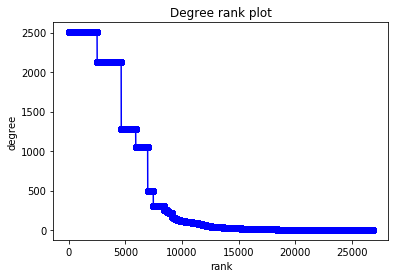

In [106]:
# adapted from: 
# https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_rank.html#sphx-glr-auto-examples-drawing-plot-degree-rank-py
plt.plot([d for n,d in degree_sequence], 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

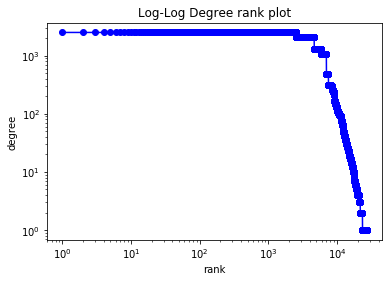

In [107]:
plt.loglog([d for n,d in degree_sequence], 'b-', marker='o')
plt.title("Log-Log Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

That looks like the first ten are outregous   
then the first thousands (the flat line) very suspect

I wonder if the piece wise nature of the curve reflects 
different dataset policy and procdures  

Off hand a couple of aproaches to reduce the counts are 
 - deleting eges for cause
 - deleting nodes (and incomming edges)
 - not adding edges in the first place
 
deleting nodes would be based on it hosting too many edges to be helpful 
but that tatic risks tossing the baby with the bath water 

the only "cause" we have for deleting an edge is the concordance count
(how many tissues these two genes have in common)
So gets some stats on that, bit it is not immediatly ob

not adding edges in the first place could be   
doing the same thing but filtering on i.e 
gold|silver but not bronze and see what it looks like.  



in the shell I did:

```
sed "s|.*'ENSG0[0-9]*,ENSG0[0-9]*': \([0-9]*\).|\1|g" <bgee_coexp_network.yaml > bgee_concordance.txt
      sort -n bgee_concordance.txt | uniq -c | sort -nr | otsu.awk
```
and got "30" which  
sugests tossing assiciations with thirty or fewer tissue measurements.  

which does not sit right with me, 
finding two genes that only agree in absent/present in thirty fissues is significant 


#### Take N+1


In [108]:
concordant = sorted(list(rel_scores.values()))

In [109]:
print("Min:\t", min(concordant))
print("Max:\t", max(concordant))
print("Mean:\t", statistics.mean(concordant))
print("Median:\t", statistics.median(concordant))
print("Mode:\t", statistics.mode(concordant))
print("StdDev:\t", statistics.pstdev(concordant))

Min:	 1
Max:	 142
Mean:	 4.810807209628574
Median:	 2.0
Mode:	 1
StdDev:	 11.0964727677232


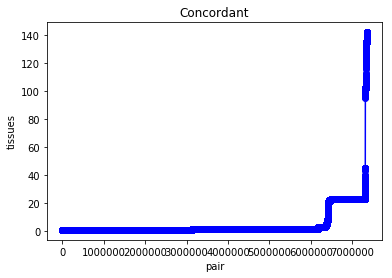

In [110]:
plt.plot(concordant, 'b-', marker='o')
plt.title("Concordant")
plt.ylabel("tissues")
plt.xlabel("pair")
plt.show()

# dont run
k=0
for n, r in  G.degree().items(): 
    if r > 1000:
        k+=1
        print(str(k) + ": removing " + n + " with " + str(r)  + " edges") 
        G.remove_node(n)

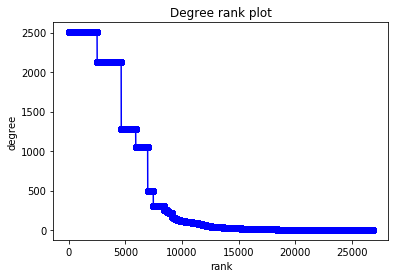

In [111]:
plt.plot([d for n,d in sorted(G.degree().items(), key=operator.itemgetter(1),  reverse=True)], 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

In [ ]:
# np.*([2,3,4], [5,7,9])

  !# Try to find NCBIGene_id for Ensenbl_ID
        # try to convert ids from ensembl to ncbi 
        gene_id = ensg_ncbi[gene_id] if gene_id in ensg_ncbi else gene_id

        !# last gasp conversion based on gene symbol
        if gene_id == ensg and gene_name in sym_ncbi:
            # print('WARN: ' + sym_ncbi[gene_name] + ' is replacing '+ ensg + ' b/c '+ gene_name)
            gene_id = sym_ncbi[gene_name]

//# read files from HGNC_nomenclature_update  
//# opposite of ...
with open('ensgid_symbol_hgnc.yaml', 'w') as fh:
    yaml.dump(ensg_sym, fh)
with open('ncbi_symbol_hgnc.yaml', 'w') as fh:
    yaml.dump(ncbi_sym, fh)    
with open('ensg_ncbi.yaml', 'w') as fh:
    yaml.dump(ensg_ncbi, fh)
 
// # update gene symbols
for gene_id in gene_tissue:
      # try to bring gene info up to date
        if gene_id in ensg_sym and gene_name != gene_names[gene_id]:
            print('NOTE: '+ ensg_sym[gene_id]+ ' is replacing ' + gene_names[gene_id] + ' b/c ' + gene_id)
            gene_names[gene_id] = ensg_sym[gene_id]
        elif gene_id in ensg_ncbi and ensg_ncbi[gene_id] in ncbi_sym \
                and  gene_names[gene_id] != ncbi_sym[ensg_ncbi[gene_id]]:
            print('NOTE: '+ ncbi_sym[ensg_ncbi[gene_id]] + ' is replacing ' + gene_name + ' b/c ' + gene_id + ' -> ' + ensg_ncbi[gene_id])
            gene_names[gene_id] = ncbi_sym[ensg_ncbi[gene_id]]
